In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_csv('/content/drive/MyDrive/train.csv')
train_df=pd.read_csv('/content/drive/MyDrive/test.csv')

In [3]:
df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


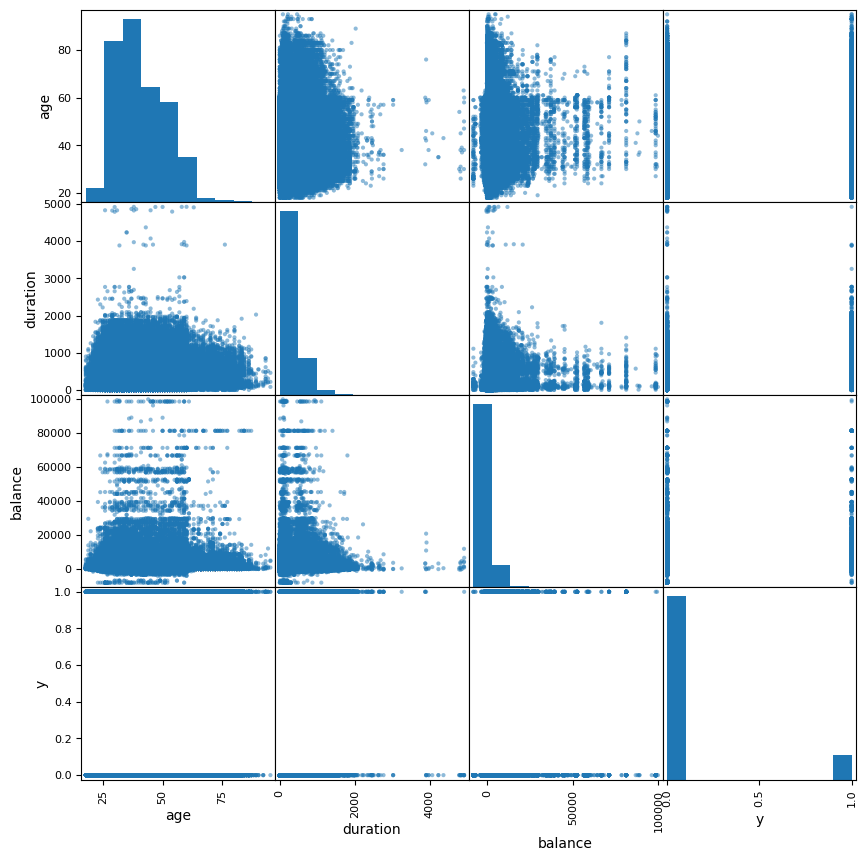

In [4]:
scatter_matrix = pd.plotting.scatter_matrix(df[['age','duration','balance','y']], figsize=(10, 10))

In [5]:
newdf= df.drop(columns=['id','poutcome'])

new_train_df=train_df.drop(columns=['id','poutcome'])

(<Axes: xlabel='duration', ylabel='balance'>,)

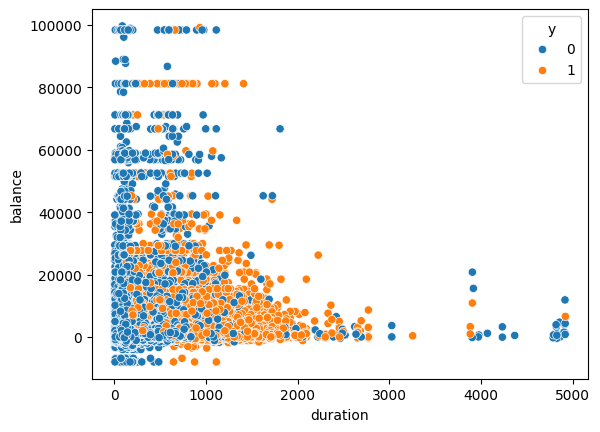

In [6]:
sns.scatterplot(x="duration", y="balance",hue='y', data=newdf),

In [7]:
categorical_cols = newdf.select_dtypes(include='object').columns.tolist() + ['day']
final_df = pd.get_dummies(newdf, columns=categorical_cols, drop_first=True)
print("Encoded DataFrame:")
display(final_df.head())

categorical_cols1 = new_train_df.select_dtypes(include='object').columns.tolist() + ['day']
final_train_df = pd.get_dummies(new_train_df, columns=categorical_cols1, drop_first=True)

Encoded DataFrame:


,age,balance,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,42,7,117,3,-1,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,38,514,185,1,-1,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,36,602,111,2,-1,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,27,34,10,2,-1,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,26,889,902,1,-1,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
numerical_cols=['age','duration','balance','pdays','previous']
scaler.fit(final_df[numerical_cols])
final_df[numerical_cols]=scaler.transform(final_df[numerical_cols])

final_train_df[numerical_cols]=scaler.transform(final_train_df[numerical_cols])

In [9]:
X=final_df.drop(columns=['y'])
Y=final_df['y']
X.shape,Y.shape

A=final_train_df
A.shape

(250000, 68)

In [10]:
import torch
X = X.astype(float)
A=A.astype(float)

X_tensor=torch.tensor(X.values,dtype=torch.float32)
Y_tensor=torch.tensor(Y.values,dtype=torch.long)

A_tensor=torch.tensor(A.values,dtype=torch.float32)

train_set=torch.utils.data.TensorDataset(X_tensor,Y_tensor)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)

test_set=torch.utils.data.TensorDataset(A_tensor)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=128,shuffle=False)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class BankANN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=68, out_features=1024)
    self.layer2 = nn.Linear(in_features=1024, out_features=512)
    self.layer3 = nn.Linear(in_features=512, out_features=128)
    self.layer4 = nn.Linear(in_features=128, out_features=2)


  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    x = self.layer4(x)

    return x

In [12]:
import torch.nn as nn

model=BankANN()
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [13]:
num_epochs = 20
for epoch in range(num_epochs):
    for batch_features, batch_labels in train_loader:
        outputs = model(batch_features)
        loss = loss_function(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.1638
Epoch [2/20], Loss: 0.1921
Epoch [3/20], Loss: 0.1299
Epoch [4/20], Loss: 0.1880
Epoch [5/20], Loss: 0.3207
Epoch [6/20], Loss: 0.0801
Epoch [7/20], Loss: 0.0712
Epoch [8/20], Loss: 0.1299
Epoch [9/20], Loss: 0.1703
Epoch [10/20], Loss: 0.0701
Epoch [11/20], Loss: 0.0543
Epoch [12/20], Loss: 0.1722
Epoch [13/20], Loss: 0.1419
Epoch [14/20], Loss: 0.1131
Epoch [15/20], Loss: 0.0769
Epoch [16/20], Loss: 0.1514
Epoch [17/20], Loss: 0.2041
Epoch [18/20], Loss: 0.0384
Epoch [19/20], Loss: 0.0930
Epoch [20/20], Loss: 0.0877


In [14]:
torch.save(model.state_dict(), 'bank_model.pth')

In [15]:
model1=BankANN()
model1.load_state_dict(torch.load('bank_model.pth'))
model1.eval()

BankANN(
  (layer1): Linear(in_features=68, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=2, bias=True)
)

In [20]:
all_probabilities = []
with torch.no_grad():
    for features_batch in test_loader:
        inputs = features_batch[0]


        logits = model(inputs)
        probabilities = torch.softmax(logits, dim=1)

        prob_y = probabilities[:, 1]


        all_probabilities.extend(prob_y.numpy())

start_id = 750000

num_predictions = len(all_probabilities)
id_column = list(range(start_id, start_id + num_predictions))
predictions_df = pd.DataFrame({
    'id': id_column,
    'probability': all_probabilities
})
predictions_df.to_csv('test_set_probabilities.csv', index=False)
print(predictions_df.head())

Successfully generated and saved 250000 predictions to 'test_set_probabilities.csv'.

First 5 predictions:
       id   probability
0  750000  2.683211e-04
1  750001  5.720189e-02
2  750002  8.488881e-07
3  750003  2.208197e-07
4  750004  1.955801e-02
